In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.sparse as sparse

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading data into dataframe

In [2]:
reviews=pd.read_csv("data/Reviews.csv",encoding='latin-1')

In [3]:
# checking shape of reviews dataframe
print(reviews.shape)

(568454, 10)


In [4]:
# drop NA's from datframe column values
reviews = reviews.dropna()

In [5]:
# recheck shape of dataframe
print (reviews.shape)

(568412, 10)


In [6]:
# check 
print (reviews.head(5))

    productId          userId                      profileName  score  \
0  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian      5   
1  B00813GRG4  A1D87F6ZCVE5NK                           dll pa      1   
2  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"      4   
3  B000UA0QIQ  A395BORC6FGVXV                             Karl      2   
4  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"      5   

         time                summary  \
0  1303862400  Good Quality Dog Food   
1  1346976000      Not as Advertised   
2  1219017600  "Delight" says it all   
3  1307923200         Cough Medicine   
4  1350777600            Great taffy   

                                                text  helpfulness_numerator  \
0  I have bought several of the Vitality canned d...                      1   
1  Product arrived labeled as Jumbo Salted Peanut...                      0   
2  This is a confection that has been around a fe...                      1   
3  I

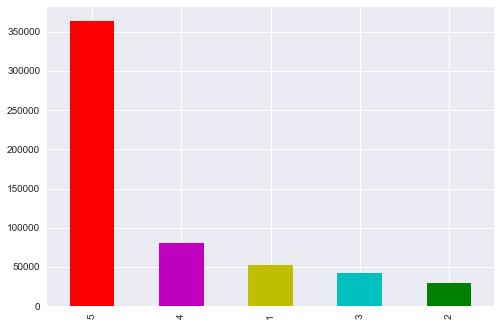

In [7]:
reviews['score'].value_counts().plot(kind='bar',color='rmycg')

In [8]:
reviews['score'].value_counts()

5    363111
4     80655
1     52264
3     42639
2     29743
Name: score, dtype: int64

In [9]:
reviews['sentiment']=reviews['score'] > 3
reviews.head(5)

,productId,userId,profileName,score,time,summary,text,helpfulness_numerator,helpfulness_denominator,date,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1,2011-04-27,True
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,2012-09-07,False
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,1,2008-08-18,True
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,3,3,2011-06-13,False
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0,0,2012-10-21,True


In [10]:
reviews.to_csv("updated.csv")

### Distribution of labels in the dataset

In [11]:
reviews.groupby('sentiment')['summary'].count()

sentiment
False    124646
True     443766
Name: summary, dtype: int64

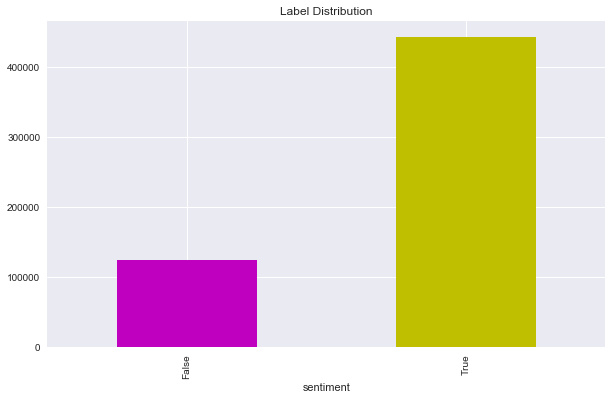

In [12]:
reviews.groupby('sentiment')['summary'].count().plot(kind='bar',color=['m','y'],title='Label Distribution',figsize=(10,6))

### Encoding score to Positive or negative based on value of each sample

In [13]:
scores = reviews['score']
reviews['score'] = reviews['score'].apply(lambda x : 'positive' if x > 3 else 'negative')

In [14]:
scores.mean()

4.183307178595808

In [15]:
reviews.groupby('score')['summary'].count()

score
negative    124646
positive    443766
Name: summary, dtype: int64

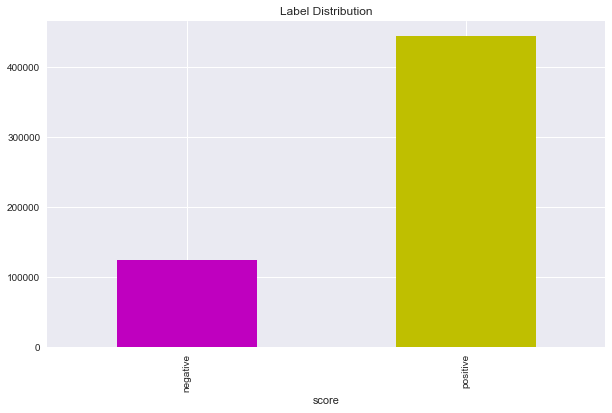

In [16]:
reviews.groupby('score')['summary'].count().plot(kind='bar',color=['m','y'],title='Label Distribution',figsize=(10,6))

In [17]:
print ('Percentage of negative reviews %.2f %%' % ((reviews.groupby('score')['summary'].count()['negative'])*100.0/len(reviews)))
print ('Percentage of positive reviews %.2f %%' % ((reviews.groupby('score')['summary'].count()['positive'])*100.0/len(reviews)))

Percentage of negative reviews 21.93 %
Percentage of positive reviews 78.07 %


### Splitting the dataset based on labels

In [18]:
def splitPosNeg(Summaries):
    negative = reviews.loc[Summaries['score']=='negative']
    positive = reviews.loc[Summaries['score']=='positive']
    return [positive,negative]

In [19]:
[positive,negative] = splitPosNeg(reviews)

### Preprocessing

#### Using lemmatization as it was giving better results than stemming. Other steps include removing punctuation amd upper case to lower case conversion.

In [20]:
#preprocessing steps

#stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        #if(t not in stop):
            #stemmed = stemmer.stem(t)
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [21]:
pos_data = []
neg_data = []
for p in positive['summary']:
    pos_data.append(preprocessing(p))

for n in negative['summary']:
    neg_data.append(preprocessing(n))

In [22]:
data = pos_data + neg_data
labels = np.concatenate((positive['score'].values,negative['score'].values))

### Splitting the data into train and test using a stratified strategy

In [23]:

[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25, random_state=20160121,stratify=labels)

#### tokenizing the training data to find frequency of words

In [24]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [25]:
word_features = nltk.FreqDist(t)
print (len(word_features))

27084


* We can see that the number of unique words in the dataset is pretty huge. When doing text classification the vocabulary of the data set becomes the featureset.
* We would want to reduce the size of this feature set. This can be done in severals ways.
* One of them is feature reduction using PCA.

### Feature Reduction

#### Using PCA (principal component analysis)

In [26]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [27]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [28]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

#### Pca doesn't apply to sparse matrices so we use a different version of PCA called Truncated SVD

In [29]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [30]:
te_features_truncated = svd.transform(te_features_all)

In [31]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

### Running 3 classification algorithms : Naive Bayes, Logistic Regression, Decision Trees

In [32]:
models = {'BernoulliNB':BernoulliNB(binarize=0.5)
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy')}

In [33]:
results_svd = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        model.fit(tr_features_truncated, Train_labels)
        tfprediction[name] = model.predict(te_features_truncated)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_truncated,Train_labels)
        #cprediction[name] = model.predict(cte_features_truncated)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)

        results_svd.loc[foldnum,'Model']=name
        results_svd.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_svd.loc[foldnum,'Count Accuracy']=caccuracy
        foldnum = foldnum+1
print (results_svd)

           Model  TF-IDF Accuracy
0       Logistic         0.844739
1  Decision Tree         0.862248
2    BernoulliNB         0.794452


In [34]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  Logistic
             precision    recall  f1-score   support

   negative       0.77      0.42      0.54     31162
   positive       0.86      0.96      0.91    110941

avg / total       0.84      0.84      0.83    142103



Classification report for  Decision Tree
             precision    recall  f1-score   support

   negative       0.69      0.69      0.69     31162
   positive       0.91      0.91      0.91    110941

avg / total       0.86      0.86      0.86    142103



Classification report for  BernoulliNB
             precision    recall  f1-score   support

   negative       0.90      0.07      0.13     31162
   positive       0.79      1.00      0.88    110941

avg / total       0.82      0.79      0.72    142103





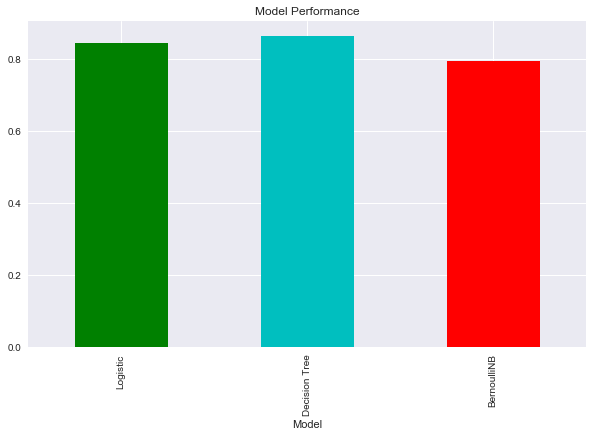

In [35]:
results_svd.plot(kind='bar',color=['g','c','r'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [36]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='negative')
    negcom.loc[name,'recall'] = p

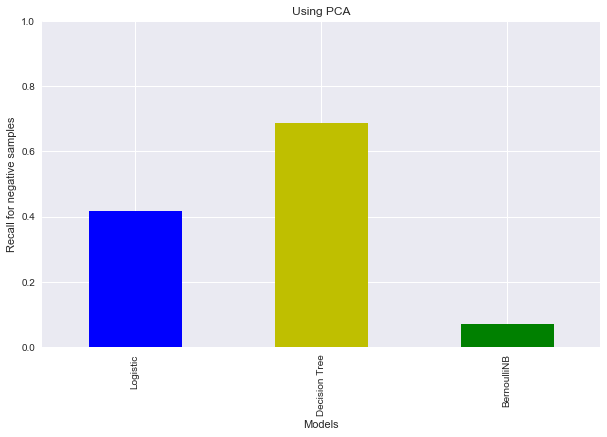

In [37]:
pl = negcom.plot(kind='bar',color=['b','y','g'],title='Using PCA',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

#### The performance seems to be okay but we can try improving it further
* Another way to reduce feature set is to have better feature selection. We can use the most frequent 5000 features as the featureset

### Feature selection

In [38]:
topwords = [fpair[0] for fpair in list(word_features.most_common(5000))]
print (word_features.most_common(25))

[('great', 54849), ('the', 41658), ('good', 38942), ('a', 38104), ('for', 30381), ('love', 27012), ('and', 26424), ('not', 25315), ('it', 25274), ('best', 25203), ('my', 21937), ('coffee', 19164), ('i', 18992), ('but', 18956), ('this', 18423), ('taste', 18104), ('tea', 17030), ('to', 15997), ('dog', 15956), ('product', 15577), ('of', 15451), ('is', 14187), ('delicious', 14020), ('s', 12939), ('very', 12002)]


In [39]:
word_his = pd.DataFrame(word_features.most_common(25),columns=['words','count'])
print (word_his)

        words  count
0       great  54849
1         the  41658
2        good  38942
3           a  38104
4         for  30381
5        love  27012
6         and  26424
7         not  25315
8          it  25274
9        best  25203
10         my  21937
11     coffee  19164
12          i  18992
13        but  18956
14       this  18423
15      taste  18104
16        tea  17030
17         to  15997
18        dog  15956
19    product  15577
20         of  15451
21         is  14187
22  delicious  14020
23          s  12939
24       very  12002


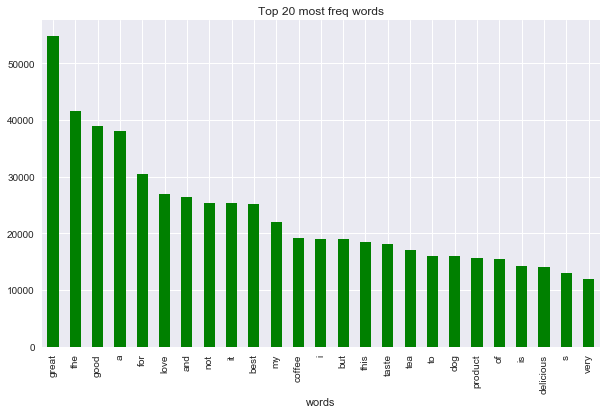

In [40]:
word_his.plot(kind='bar',x=word_his['words'],color='g',legend=False,title='Top 20 most freq words',figsize=(10,6))

In [41]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

In [42]:
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [43]:
ctr_features = vec.transform(Data_train)
tr_features = tf_vec.transform(ctr_features)
print(tr_features)

  (0, 4532)	0.57735026919
  (0, 1498)	0.57735026919
  (0, 433)	0.57735026919
  (1, 4549)	0.4472135955
  (1, 3004)	0.4472135955
  (1, 1691)	0.4472135955
  (1, 282)	0.4472135955
  (1, 165)	0.4472135955
  (2, 4695)	0.57735026919
  (2, 1906)	0.57735026919
  (2, 1799)	0.57735026919
  (3, 4636)	0.408248290464
  (3, 4414)	0.408248290464
  (3, 2626)	0.408248290464
  (3, 2178)	0.408248290464
  (3, 1412)	0.408248290464
  (3, 719)	0.408248290464
  (4, 4872)	0.333333333333
  (4, 4409)	0.333333333333
  (4, 3442)	0.333333333333
  (4, 3024)	0.666666666667
  (4, 617)	0.333333333333
  (4, 326)	0.333333333333
  (5, 4467)	0.4472135955
  (5, 3024)	0.4472135955
  :	:
  (426300, 4302)	0.57735026919
  (426300, 1791)	0.57735026919
  (426300, 203)	0.57735026919
  (426301, 3024)	0.707106781187
  (426301, 326)	0.707106781187
  (426302, 3790)	0.707106781187
  (426302, 1956)	0.707106781187
  (426303, 3930)	0.408248290464
  (426303, 2553)	0.408248290464
  (426303, 2322)	0.408248290464
  (426303, 958)	0.408248290464

In [44]:
cte_features = vec.transform(Data_test)
te_features = tf_vec.transform(cte_features)
print (te_features)

  (0, 4469)	0.4472135955
  (0, 4187)	0.4472135955
  (0, 1956)	0.4472135955
  (0, 1362)	0.4472135955
  (0, 617)	0.4472135955
  (1, 4467)	0.408248290464
  (1, 4424)	0.408248290464
  (1, 2990)	0.408248290464
  (1, 2944)	0.408248290464
  (1, 1613)	0.408248290464
  (1, 1395)	0.408248290464
  (2, 3464)	0.707106781187
  (2, 188)	0.707106781187
  (3, 4409)	0.408248290464
  (3, 3442)	0.408248290464
  (3, 3178)	0.408248290464
  (3, 1524)	0.408248290464
  (3, 389)	0.408248290464
  (3, 203)	0.408248290464
  (4, 4253)	0.707106781187
  (4, 1956)	0.707106781187
  (5, 4641)	0.408248290464
  (5, 4467)	0.408248290464
  (5, 4349)	0.408248290464
  (5, 3024)	0.408248290464
  :	:
  (142095, 4038)	0.408248290464
  (142095, 2771)	0.408248290464
  (142095, 2168)	0.408248290464
  (142096, 2432)	0.57735026919
  (142096, 353)	0.57735026919
  (142096, 248)	0.57735026919
  (142097, 4402)	0.5
  (142097, 4365)	0.5
  (142097, 2899)	0.5
  (142097, 1788)	0.5
  (142098, 4550)	0.57735026919
  (142098, 1956)	0.57735026919


In [45]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy')}

In [46]:
results = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features, Train_labels)
        tfprediction[name] = model.predict(te_features)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features,Train_labels)
        #cprediction[name] = model.predict(cte_features)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results.loc[foldnum,'Count Accuracy']=caccuracy
        results.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results)

   TF-IDF Accuracy          Model
0         0.887870       Logistic
1         0.914822  Decision Tree
2         0.870045    BernoulliNB


In [47]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  Logistic
             precision    recall  f1-score   support

   negative       0.80      0.65      0.72     31162
   positive       0.91      0.95      0.93    110941

avg / total       0.88      0.89      0.88    142103



Classification report for  Decision Tree
             precision    recall  f1-score   support

   negative       0.83      0.77      0.80     31162
   positive       0.94      0.95      0.95    110941

avg / total       0.91      0.91      0.91    142103



Classification report for  BernoulliNB
             precision    recall  f1-score   support

   negative       0.72      0.66      0.69     31162
   positive       0.91      0.93      0.92    110941

avg / total       0.87      0.87      0.87    142103





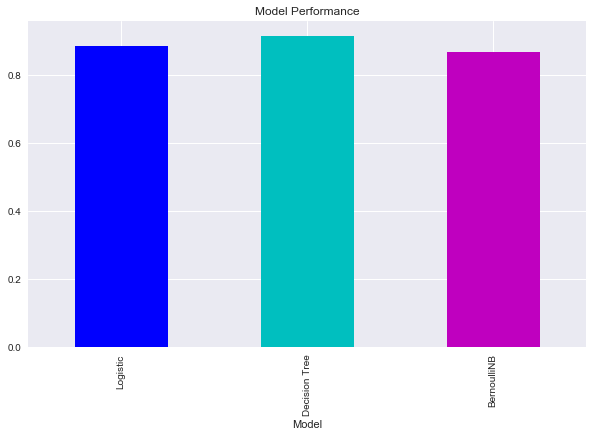

In [48]:
results.plot(kind='bar',color = 'bcm', title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [49]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='negative')
    negcom.loc[name,'recall'] = p

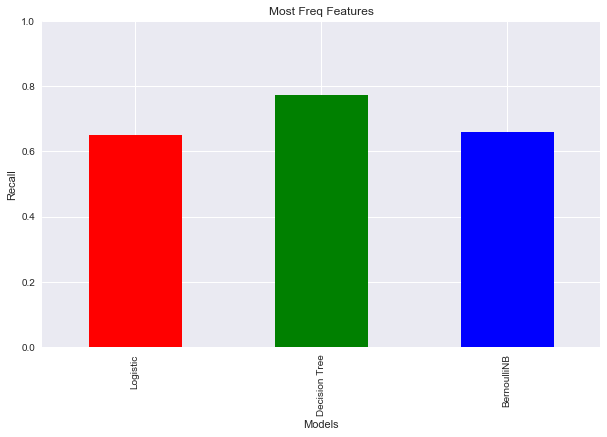

In [50]:
pl = negcom.plot(kind='bar',color=['r','g','b'],title='Most Freq Features',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall')
lim = plt.ylim([0,1])

* Finally we can try by running it on our entire featureset. One can guess it will take a lot of time with Decision Tree Classifier.
* We can make use of group of words to get better results. Sometimes sequence of words might have different effect on the prediction. Sequences like "not good" or "not bad" affect the prediction in way different than when used individually

### Using Bigrams

In [51]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [52]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [53]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [54]:
print ((ctr_features_all.shape))

(426309, 263810)


In [55]:
results_all_bi = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_bi.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_bi.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_bi.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_bi)

   TF-IDF Accuracy          Model
0         0.928770       Logistic
1         0.916413  Decision Tree
2         0.886561    BernoulliNB


In [56]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  Logistic
             precision    recall  f1-score   support

   negative       0.87      0.80      0.83     31162
   positive       0.94      0.97      0.95    110941

avg / total       0.93      0.93      0.93    142103



Classification report for  Decision Tree
             precision    recall  f1-score   support

   negative       0.82      0.79      0.81     31162
   positive       0.94      0.95      0.95    110941

avg / total       0.92      0.92      0.92    142103



Classification report for  BernoulliNB
             precision    recall  f1-score   support

   negative       0.79      0.66      0.72     31162
   positive       0.91      0.95      0.93    110941

avg / total       0.88      0.89      0.88    142103





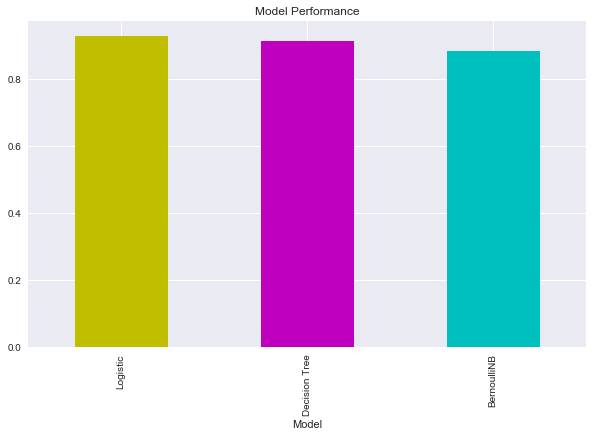

In [57]:
results_all_bi.plot(kind='bar',color=['y','m','c'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [58]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='negative')
    negcom.loc[name,'recall'] = p

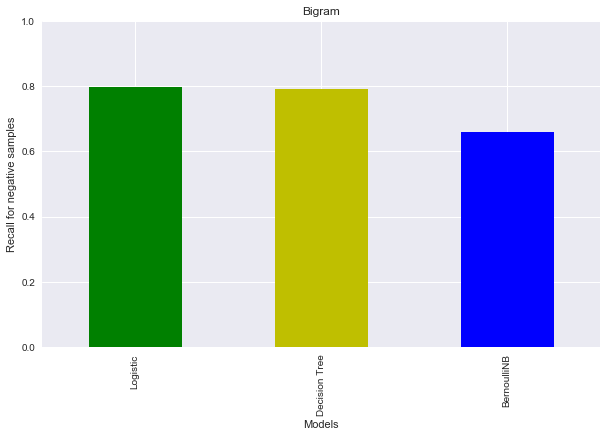

In [59]:
pl = negcom.plot(kind='bar',color=['g','y','b'],title='Bigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

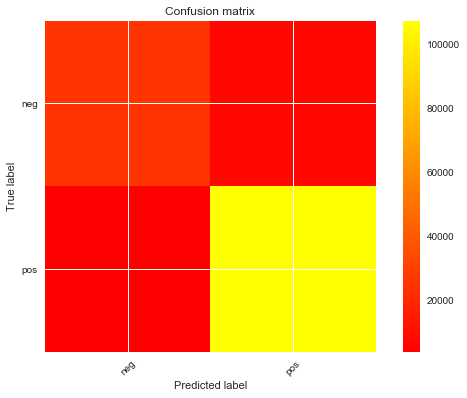

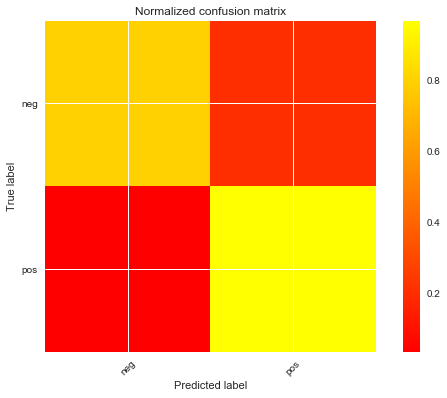

In [60]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.autumn):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(labels)))
    plt.xticks(tick_marks, ['neg','pos'], rotation=45)
    plt.yticks(tick_marks, ['neg','pos'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Test_labels, tfprediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [63]:
top_good=[]
if reviews['score'] ==5:
    
     print (reviews['text'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().